In [1]:
# Change directory to level up to import functions
import os
os.chdir('..')

In [42]:
from src.data_prep.join_data import load_combine_fpl_data

from src.tools.yaml_loader import load_yaml_file

# Load parameters
file_path = "conf/parameters.yaml"
parameters = load_yaml_file(file_path)
number_gameweeks_played_min = parameters["number_gameweeks_played_min"]
import pandas as pd
fpl_data = pd.read_csv("data/fpl_data/joined/seasons_joined.csv")
# Filter to only players who have played more than the specified
df = fpl_data[fpl_data["count_gws_min_minutes"] >= number_gameweeks_played_min]

# Drop Cole Palmer anomoly season
#df = fpl_data.drop(fpl_data[(fpl_data["name"] == "Cole Palmer") & (fpl_data["season"] == "2023-24")].index)

team_strength_threshold =5
#df = df[df['team_strength']<=team_strength_threshold]


In [16]:
import statsmodels.api as sm

In [53]:

# Define features (independent variables) and target (dependent variable)
X = df[['value_first_gw', 'promoted_from_championship']]  # Features
y = df['total_points']  # Target

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Get the model summary including coefficients and p-values
summary = model.summary()

summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_points   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     460.2
Date:                Wed, 16 Oct 2024   Prob (F-statistic):          2.97e-154
Time:                        22:53:01   Log-Likelihood:                -6817.7
No. Observations:                1400   AIC:                         1.364e+04
Df Residuals:                    1397   BIC:                         1.366e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         15.9619      3.380      4.722      0.000       9.331      22.593
value_first_gw                 1.6378      0.056     29.162      0.000       1.528       1.748
promoted_from_championship    -5.2948      2.438     -2.172      0.030     -10.078      -0.512
==============================================================================
Omnibus:                       73.214   Durbin-Watson:                   0.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.218
Skew:                           0.566   Prob(JB):                     5.16e-19
Kurtosis:                       3.404   Cond. No.                         245.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
import statsmodels.formula.api as smf

# Fit the ANCOVA model using a formula notation
# total_points ~ value_first_gw + promoted_from_championship
ancova_model = smf.ols('total_points ~ value_first_gw + promoted_from_championship', data=df).fit()

# Summary of the ANCOVA
print(ancova_model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     460.2
Date:                Wed, 16 Oct 2024   Prob (F-statistic):          2.97e-154
Time:                        22:53:12   Log-Likelihood:                -6817.7
No. Observations:                1400   AIC:                         1.364e+04
Df Residuals:                    1397   BIC:                         1.366e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [56]:

import pingouin as pg

# Perform ANCOVA
ancova_results = pg.ancova(dv='total_points', between='promoted_from_championship', covar='value_first_gw', data=df)

# Show results
print(ancova_results)

                       Source            SS    DF           F          p-unc  \
0  promoted_from_championship  4.697166e+03     1    4.715870   3.005324e-02   
1              value_first_gw  8.470440e+05     1  850.416924  2.034435e-146   
2                    Residual  1.391459e+06  1397         NaN            NaN   

        np2  
0  0.003364  
1  0.378397  
2       NaN  


In [5]:
#df = df.drop(df[(df["name"] == "Cole Palmer") & (df["season"] == "2023-24")].index)

# Perform t-tests
team_strength_threshold = 5
result_df = perform_ttest_on_df(df, team_strength_threshold=team_strength_threshold)

# Sample size filter
sample_size_threshold = 20
result_df = format_result(
    result_df=result_df, sample_size_threshold=sample_size_threshold, export_csv=True
)
result_df

c:\Users\edwar\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1113: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\edwar\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1113: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\edwar\OneDrive\Documents\08_Hobbies\01_Edward\01_Fantasy_Football\05_Championship Analysis\fpl-championship-analysis\src\analysis\ttest.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["statistically_significant"] = np.where(
c:\Users\edwar\OneDrive\Documents\08_Hobbies\01_

,Position,Value,Avg. Score Promoted,Avg. Score Not Promoted,Difference,Statistically Significant,Num. Players Promoted,Num. Players Not Promoted,T-Test,P-Value
13,GK,45,115.2,112.7,2.5,No,19,38,0.28,0.781
12,DEF,40,65.3,84.7,-19.4,No,7,13,-1.14,0.283
10,DEF,45,81.1,82.8,-1.7,No,73,179,-0.46,0.649
11,DEF,50,82.2,94.8,-12.6,No,6,135,-0.74,0.492
2,MID,45,81.0,76.9,4.1,No,17,41,0.67,0.506
4,MID,50,78.0,90.6,-12.6,Yes,24,121,-2.92,0.005
1,MID,55,97.2,98.1,-0.9,No,24,116,-0.14,0.887
0,MID,60,109.0,110.8,-1.8,No,7,56,-0.15,0.886
3,MID,65,116.5,129.6,-13.1,No,2,41,-0.57,0.664
5,FWD,60,108.9,118.1,-9.2,No,8,18,-0.76,0.458


In [72]:
df = goals_championship_fpl_points[(goals_championship_fpl_points['Position']=='FWD') ]

# Calculate correlation matrix
correlation_matrix  = df[['FPL Points', 'FPL Value', 'Championship Goals']].corr()
average_stats = goals_championship_fpl_points.groupby('FPL Value')[['FPL Points', 'Championship Goals']].mean().reset_index()



# Display the correlation matrix
print(correlation_matrix)
print(average_stats)

# This shows Championship goals does transalte to more FPL Points after promotion. 
# However these players are priced based on this performance in the championship. 
# 

                    FPL Points  FPL Value  Championship Goals
FPL Points            1.000000   0.631427            0.649710
FPL Value             0.631427   1.000000            0.789982
Championship Goals    0.649710   0.789982            1.000000
   FPL Value  FPL Points  Championship Goals
0       40.0   19.800000            1.066667
1       45.0   49.752212            2.336283
2       50.0   39.141026            3.397436
3       55.0   51.719298            7.368421
4       60.0   91.157895           15.473684
5       65.0  109.222222           22.666667


In [56]:
goals_championship_fpl_points('FPL Points','FPL Value')

TypeError: 'DataFrame' object is not callable

In [18]:

season_years = [
    "2016-17",
    "2017-18",
    "2018-19",
    "2019-20",
    "2020-21",
    "2021-22",
    "2022-23",
    "2023-24",
]

# Load and save data
df = load_combine_fpl_data(season_years=season_years, export_csv=True)

#### Background
This analysis look at the Fantasy Premier League (FPL) performance of players from Championship teams, in their first season after being promoted to the Preimier League. See notes and caveats at the end.

The following areas are looked into:
* An exploratory data analysis of how these players perform.
  * Top performances from players in promoted teams
  * Top total team points from promoted teams
  * Championship goals and assits vs FPL Points in the following season
* A comparison of players from promoted teams with players from teams already in the league.
  * Overview of differences for each price point by position (link to ttest eli5/youtube vidoe)
  * £5.0m midfielders detail

#### Key Findings
* In general, avoid £5.0m midfielders from newly promoted teams; consider players from others teams instead.
* There is no statistically significant difference in player performance from promoted vs existing teams at other price points or positions, by different team strengths.
* Goals and assists in the Championship don’t always translate into Fantasy Premier League (FPL) points the following season.
* Patrick Bamford had a good season in 2020/21.

In [2]:
import pandas as pd

In [3]:
fpl_data = pd.read_csv("data/fpl_data/joined/seasons_joined.csv")
goals_championship_fpl_points = pd.read_csv(
    "data/analysis/goals_championship_fpl_points.csv"
)
assists_championship_fpl_points = pd.read_csv(
    "data/analysis/assists_championship_fpl_points.csv"
)
team_performance_fpl_points = pd.read_csv(
    "data/analysis/team_performance_fpl_points.csv"
)
welchs_ttest = pd.read_csv("data/analysis/welchs_ttest.csv")


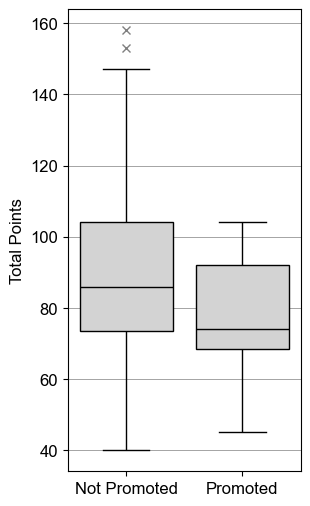

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from src.tools.yaml_loader import load_yaml_file

# Load parameters
file_path = "conf/parameters.yaml"
parameters = load_yaml_file(file_path)
number_gameweeks_played_min = parameters["number_gameweeks_played_min"]

fpl_data_50_mid = fpl_data[(fpl_data['value_first_gw']==50) & (fpl_data['position']=='MID')]

# Drop Cole Palmer anomoly season
fpl_data_50_mid = fpl_data_50_mid.drop(fpl_data_50_mid[(fpl_data_50_mid["name"] == "Cole Palmer") & (fpl_data_50_mid["season"] == "2023-24")].index)

# Filter to only players who have played more than the specified
fpl_data_50_mid = fpl_data_50_mid[fpl_data_50_mid["count_gws_min_minutes"] >= number_gameweeks_played_min]

promoted = fpl_data_50_mid[fpl_data_50_mid['promoted_from_championship'] == 1]['total_points']
not_promoted = fpl_data_50_mid[fpl_data_50_mid['promoted_from_championship'] == 0]['total_points']


# Set font properties to match Streamlit
plt.rcParams['font.family'] = 'sans-serif'  # Use a sans-serif font
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 12               # Set a default font size

# Example Data (replace this with your actual data)
# fpl_data_50_mid = your_actual_dataframe

plt.figure(figsize=(3, 6))

# Create the boxplot with light grey boxes and black lines
sns.boxplot(data=fpl_data_50_mid, x="promoted_from_championship", y="total_points",
            flierprops={"marker": "x"}, color='lightgrey',
            boxprops=dict(edgecolor='black'),  # Black edges for the box
            medianprops=dict(color='black'),    # Black median line
            whiskerprops=dict(color='black'),   # Black whiskers
            capprops=dict(color='black'))        # Black caps on the whiskers

# Relabel the x and y axes
plt.xlabel('')
plt.ylabel('Total Points')

# Replace 0 with 'Promoted' and 1 with 'Not Promoted' on the x-axis
plt.xticks(ticks=[0, 1], labels=['Not Promoted', 'Promoted'])

# Calculate the median or mean for each category
medians = fpl_data_50_mid.groupby('promoted_from_championship')['total_points'].median()

# Add grey horizontal gridlines
plt.grid(axis='y', color='grey', linewidth=0.5) 

plt.savefig('assets/mid_50_boxplot.png', bbox_inches='tight')


#### Notes and Caveats


Other things I assessed 
Experiemneted with different thresholds of definition for games played (mins/gws)
Built models to predict scores to see if championship flag was an important feature/significant. Similar restults to t tests.

Note this isn't looking only at players who played in the chapmionship the season before. It includes new signings that season.

We're only looking at players in teams promoted. 
Not players from promoted teams as that can be influnced by the strength of the club they are going to. 
E.g. When Tottenham signed Bale etc. This would be a seperate piece of analysis assesing the impact of signings 
from dif

In [5]:
fpl_data.columns

Index(['name', 'team', 'total_points', 'position', 'goals_scored', 'assists',
       'clean_sheets', 'yellow_cards', 'red_cards', 'goals_conceded',
       'own_goals', 'penalties_missed', 'penalties_saved', 'saves',
       'bonus_points', 'value_first_gw', 'count_gws_min_minutes',
       'team_strength', 'team_strength_overall_home',
       'team_strength_overall_away', 'team_strength_attack_home',
       'team_strength_attack_away', 'team_strength_defence_home',
       'team_strength_defence_away', 'season', 'promoted_from_championship',
       'season_start', 'name_season'],
      dtype='object')

In [6]:
from src.tools.app_tools import top_players_fpl_data

c:\Users\edwar\AppData\Local\Programs\Python\Python311\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [7]:
top_players_fpl_data(df=fpl_data, filter_position='All', top_n=20)

c:\Users\edwar\OneDrive\Documents\08_Hobbies\01_Edward\01_Fantasy_Football\05_Championship Analysis\fpl-championship-analysis\src\analysis\championship_player_performance.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Rank"] = df[metric].rank(method="min", ascending=False)


,Player,Season,Total Points,Position,Team,Total Points per Game,Goals,Assists,saves,Goals Conceded
2089,Patrick Bamford,2020-21,194,FWD,Leeds,5.1,17,11,0,50
1046,Raúl Jiménez,2018-19,181,FWD,Wolves,4.8,13,10,0,40
2093,Stuart Dallas,2020-21,171,DEF,Leeds,4.5,8,3,0,53
541,Pascal Groß,2017-18,164,MID,Brighton,4.3,7,8,0,46
1579,Dean Henderson,2019-20,160,GK,Sheffield Utd,4.2,0,1,97,33
2097,Jack Harrison,2020-21,160,MID,Leeds,4.2,8,10,0,45
1066,Neil Etheridge,2018-19,154,GK,Cardiff,4.1,0,0,141,69
2099,Illan Meslier,2020-21,154,GK,Leeds,4.1,0,0,140,52
2100,Matheus Pereira,2020-21,153,MID,West Brom,4.0,11,7,0,58
25,Tom Heaton,2016-17,149,GK,Burnley,3.9,0,0,142,48


In [8]:
welchs_ttest

,Position,Value,Avg. Score Promoted,Avg. Score Not Promoted,Difference,Statistically Significant,Num. Players Promoted,Num. Players Not Promoted,T-Test,P-Value
0,GK,45,115.2,112.7,2.5,No,19,38,0.28,0.781
1,DEF,45,81.1,80.3,0.8,No,73,161,0.21,0.831
2,DEF,50,82.2,88.4,-6.2,No,6,98,-0.36,0.730
3,MID,45,81.0,76.4,4.6,No,17,37,0.75,0.461
4,MID,50,78.0,86.5,-8.6,Yes,24,90,-2.02,0.049
5,MID,55,97.2,100.1,-2.9,No,24,81,-0.43,0.668
6,MID,60,109.0,110.0,-1.0,No,7,43,-0.08,0.939
7,MID,65,116.5,125.9,-9.4,No,2,30,-0.40,0.749
8,FWD,60,108.9,118.1,-9.2,No,8,18,-0.76,0.458
9,FWD,65,121.6,119.3,2.2,No,7,18,0.25,0.805
